In [834]:
import os
#set your environment variable for SSL certificate
certi_path = r"C:\Users\bertr\AppData\Local\Programs\Python\Python39\Lib\site-packages\pip\_vendor\certifi\cacert.pem"
os.environ['REQUESTS_CA_BUNDLE'] = certi_path
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import requests
import random
import time
import json
import pandas as pd
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains


In [835]:
def initialize_driver(headers_list, proxy_list):
    options = Options()
    #select a random user-agent from the list
    user_agent = random.choice(headers_list)["User-Agent"]
    options.add_argument(f"user-agent={user_agent}")
    
    #select a random proxy from the list
    proxy = random.choice(proxy_list)
    if proxy:
        options.add_argument(f"--proxy-server={proxy}")
    
    #add some common options
    options.add_argument("--headless")
    options.add_argument("--disable-extensions")
    options.add_argument("--ignore-certificate-errors")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    chrome_prefs = {}
    options.experimental_options["prefs"] = chrome_prefs
    chrome_prefs["profile.default_content_settings"] = {"images": 2}
    
    #initialize Chrome WebDriver with the specified options
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    #set implicit wait of 10sec
    driver.implicitly_wait(10)

    return driver

In [836]:
def MainPage(driver, url):
    driver.get(url)
    time.sleep(2)

In [837]:
def nbHisytoryByPage(driver):
    try:
        liste_histoires = driver.find_element(By.ID, "liste_histoires")
        search_results = driver.find_elements(By.TAG_NAME, "article")
        search_results_count = len(search_results)
        return search_results_count

    except Exception as e:
        print("An error occurred in nbHisytoryByPage:", str(e))
        return 0  # Or handle the exception as needed

In [838]:
def nbHisytoryTot(driver):
    try:
        search_results = driver.find_element(By.CSS_SELECTOR, 'div[class="row align-items-center gy-2 mb-4 pb-1 pb-sm-2 pb-lg-3"]')
        text_nb_hostory_tot = search_results.find_element(By.CSS_SELECTOR, 'h2[class="mb-lg-0"]').text.split('(')[1].split(')')[0]
        return int(text_nb_hostory_tot)

    except Exception as e:
        print("An error occurred in nbHisytoryTot:", str(e))
        return 0  # Or handle the exception as needed

In [864]:
def Click(driver, pos):
    '''Click on the link'''
    print(pos)
    print(len(driver.find_elements(By.CSS_SELECTOR, 'a[class="btn btn-sm btn-primary mb-1"]')))
    try:
        element = driver.find_elements(By.CSS_SELECTOR, 'a[class="btn btn-sm btn-primary mb-1"]')[pos]
        wait = WebDriverWait(driver, 10)  # Attend jusqu'à 10 secondes au maximum
        element = wait.until(EC.element_to_be_clickable(element))
        actions = ActionChains(driver)
        actions.move_to_element(element).perform()
        element.click()
        return 1

    except Exception as e:
        print("An error occurred in Click:", str(e))
        return 0

In [840]:
def ClickMoreHistory(driver):
    '''Click on the link'''
    try:
        wait = WebDriverWait(driver, 10)  # Attend jusqu'à 10 secondes au maximum
        element = wait.until(EC.element_to_be_clickable((By.ID, 'loadmorebtn')))
        actions = ActionChains(driver)
        actions.move_to_element(element).perform()
        element.click()
        return 1

    except Exception as e:
        print("An error occurred in ClickMoreHistory:", str(e))
        return 0

In [841]:
def GetDatas(driver, story):
    try:
        age = driver.find_elements(By.CSS_SELECTOR, 'span[class="badge border border-light text-light fs-sm mb-1"]')[1].text
        title = driver.find_element(By.CSS_SELECTOR, 'h1[class="display-2 mb-4"]').text
        history = driver.find_element(By.CSS_SELECTOR, 'div[class="col-lg-9 col-xl-8"]').find_element(By.CSS_SELECTOR, 'div[class="fs-lg"]').get_attribute("outerHTML")
        lien_type_history = driver.find_element(By.CSS_SELECTOR, 'ol[class="pt-lg-3 pb-lg-4 pb-2 breadcrumb"]').find_elements(By.TAG_NAME, 'li')
        category = lien_type_history[3].find_element(By.TAG_NAME, 'a').text
        genre = lien_type_history[4].find_element(By.TAG_NAME, 'a').text

        # Récupération des questions et des réponses
        question_histoire = []
        try:
            accordion_question = driver.find_element(By.ID, "collapseOne")
            all_questions = accordion_question.find_elements(By.CSS_SELECTOR, 'h3[class="lead"]')
            for i in range(0, len(all_questions)):
                div_responses = accordion_question.find_elements(By.CSS_SELECTOR, 'div[class="card mb-4"]')[i]
                all_responses = div_responses.find_elements(By.CSS_SELECTOR, 'label[class="form-check-label"]')
                correction = driver.find_elements(By.CLASS_NAME, 'text-success')[i]
                tab_response = []
                for a in range(0, len(all_responses)):
                    tab_response.append(all_responses[a].get_attribute("textContent"))
                question_histoire.append({
                    "question" + str(i+1): {
                        "enonce":  accordion_question.find_elements(By.CSS_SELECTOR, 'h3[class="lead"]')[i].get_attribute("textContent"),
                        "responses": tab_response,
                        "correction": correction.get_attribute("id").split('_')[2]
                    }
                })
        except NoSuchElementException:
            print("Element collapseOne n'existe pas. Le quiz sera vide.")

        # Récupération du glossaire
        dictionnaire_glossaire = {}
        try:
            accordion_glossaire = driver.find_element(By.ID, "collapseTwo").find_element(By.TAG_NAME, 'dl')
            mots = accordion_glossaire.find_elements(By.TAG_NAME, 'dt')
            defs = accordion_glossaire.find_elements(By.TAG_NAME, 'dd')
            for i in range(0, len(mots)):
                dictionnaire_glossaire[mots[i].get_attribute("textContent")] = defs[i].get_attribute("textContent")
        except NoSuchElementException:
            print("Element collapseTwo n'existe pas. Le glossaire sera vide.")

        current_story = [age, title, history, category, genre, question_histoire, dictionnaire_glossaire]
        story.append(current_story)

        # Écriture dans le fichier
        with open('history.txt', 'a') as f:
            f.write(str(current_story))
            print(f'Écriture du travail : {driver.current_url}')
            f.write('\n')

        return 1

    except Exception as e:
        print(f"Erreur lors de l'analyse HTML : {e}")

In [866]:
driver = initialize_driver([
    {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.9",
        "Host": "httpbin.org",
        "Sec-Ch-Ua": "\"Chromium\";v=\"92\", \" Not A;Brand\";v=\"99\", \"Google Chrome\";v=\"92\"",
        "Sec-Ch-Ua-Mobile": "?0",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    },
    {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.5",
        "Host": "httpbin.org",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:90.0) Gecko/20100101 Firefox/90.0"
    },
    {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.5",
        "Host": "httpbin.org",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Mobile/15E148 Safari/604.1"
    },
    {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-GB,en;q=0.5",
        "Host": "httpbin.org",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:54.0) Gecko/20100101 Firefox/54.0"
    },
    {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.9",
        "Host": "httpbin.org",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.2 Safari/605.1.15"
    }
], [False])

In [867]:
MainPage(driver, r"https://www.meshistoiresdusoir.fr/g/histoires-fantastiques/")

In [868]:
nbHisytoryTotVar = nbHisytoryTot(driver)

In [869]:
nbHisytoryByPageVar = nbHisytoryByPage(driver)

In [870]:
nb_page = nbHisytoryTotVar // nbHisytoryByPageVar
if nbHisytoryTotVar % nbHisytoryByPageVar != 0:
    nb_page = nb_page + 1

In [871]:
story = []
nb_history_page_init = nbHisytoryByPage(driver)
counter = 0
for a in range(0, nb_page):
    for i in range(0, 12):
        if counter != nbHisytoryTotVar:
            for t in range(0, a):
                time.sleep(0.5)
                ClickMoreHistory(driver)
                time.sleep(0.5)
            Click(driver, counter)
            GetDatas(driver, story)
            counter = counter + 1
            driver.back()
        else:
            break

0
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/elian-le-jeune-sorcier-de-lenchantement/
1
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/les-aventures-delara-sorciere-de-lumeria/
2
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/eliane-gardienne-de-la-foret-enchantee/
3
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/les-secrets-de-mythoria/
4
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/la-quete-des-dragons-chocolates/
5
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/la-pierre-sacree-la-quete-de-lelue/
6
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/lelue-des-etoiles/
7
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/orion-le-voyageur-des-etoiles/
8
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/la-legende-delara-guerriere-du-royaume/
9
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/les-chroniques-demeric-la-quete-des-artefacts-magiques/
10
12
É

KeyboardInterrupt: 

In [872]:
df = pd.DataFrame(story)
df.columns = ["Age", "Titre", "Histoire", "Category", "Genre", "Questions", "Glossaire"]
df = df.sort_values(by=['Age', 'Category', 'Genre'], ascending=[False, False, False])
df

,Age,Titre,Histoire,Category,Genre,Questions,Glossaire
75,9 ans et plus,Le Voyageur des Étoiles et l'Orbe de Lumière,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Hommes,[{'question1': {'enonce': 'Quel est le nom du ...,{'Interplanétaire': 'Qui concerne plusieurs pl...
124,9 ans et plus,Léo et le Dragon Magique,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Hommes,[{'question1': {'enonce': 'Quel était le nom d...,"{'Contrées': 'Régions ou territoires', 'Mystér..."
76,9 ans et plus,Luna et les étoiles mystérieuses,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Femmes,[{'question1': {'enonce': 'Quelle est la coule...,{'Runes': 'Des symboles magiques utilisés pour...
123,9 ans et plus,L'Étoile Magique d'Astra,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Femmes,[{'question1': {'enonce': 'Comment s'appelle l...,"{'Firmament': 'L'espace céleste, la voûte du c..."
115,9 ans et plus,Les Pouvoirs de Léo,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Science Fantasy,Garçons,[{'question1': {'enonce': 'Quel est le nom du ...,{'Inscriptions': 'Gravures ou marques qui sont...
...,...,...,...,...,...,...,...
52,3/4 ans,Louis et Harold : Le Royaume Magique de l'Aven...,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy humoristique (light fantasy),Garçons,[{'question1': {'enonce': 'Quel est le nom du ...,{'Baguette magique': 'Bâton magique utilisé po...
78,3/4 ans,Les Aventures Magiques de Super Léo,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy humoristique (light fantasy),Garçons,[{'question1': {'enonce': 'Comment s'appelle l...,{'Intrigué': 'Qui se sent curieux ou intéressé...
38,3/4 ans,Les Aventures Magiques de Lila dans la Forêt E...,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy humoristique (light fantasy),Filles,[{'question1': {'enonce': 'Quel est le nom de ...,{'Lisière': 'La bordure ou le bord d'une forêt...
51,3/4 ans,Léa et la Petite Fée Farfelue,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy humoristique (light fantasy),Filles,[{'question1': {'enonce': 'Que cherchait la Pe...,"{'Farfelue': 'Qui est un peu excentrique, extr..."


<Axes: title={'center': "Nombre d'histoire par age"}, xlabel='Age', ylabel="Nombre d'histoire">

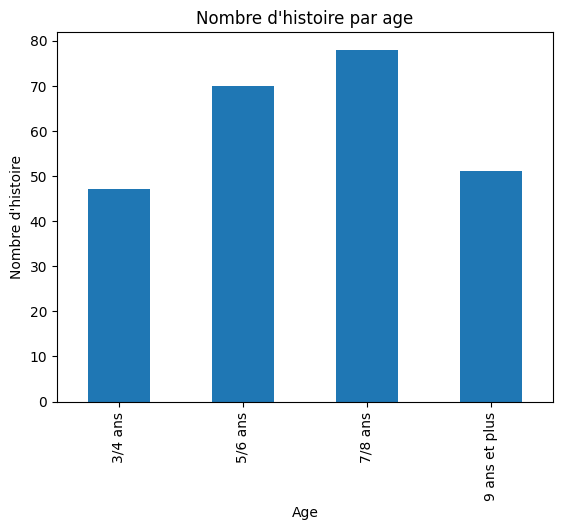

In [873]:
age_story_count = df['Age'].value_counts().sort_index()
age_story_count.plot(kind='bar', xlabel='Age', ylabel='Nombre d\'histoire', title='Nombre d\'histoire par age')

<Axes: title={'center': "Nombre d'histoire par category"}, xlabel='Category', ylabel="Nombre d'histoire">

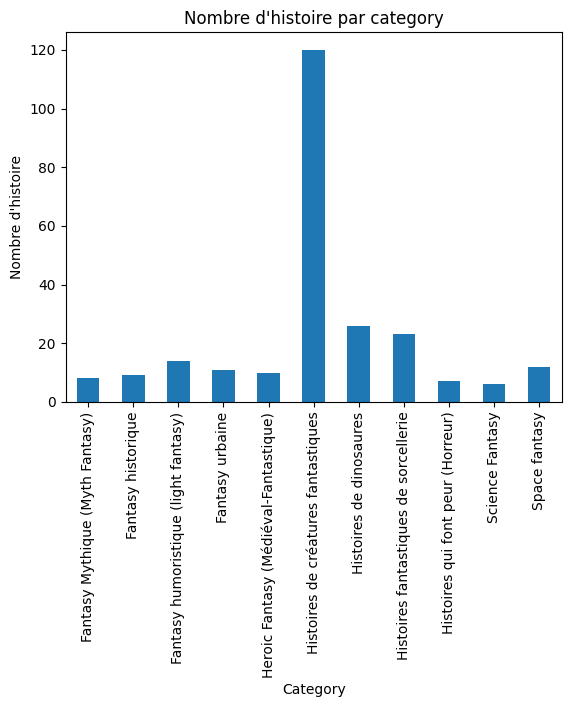

In [874]:
category_story_count = df['Category'].value_counts().sort_index()
category_story_count.plot(kind='bar', xlabel='Category', ylabel='Nombre d\'histoire', title='Nombre d\'histoire par category')

<Axes: title={'center': "Nombre d'histoire par genre"}, xlabel='Genre', ylabel="Nombre d'histoire">

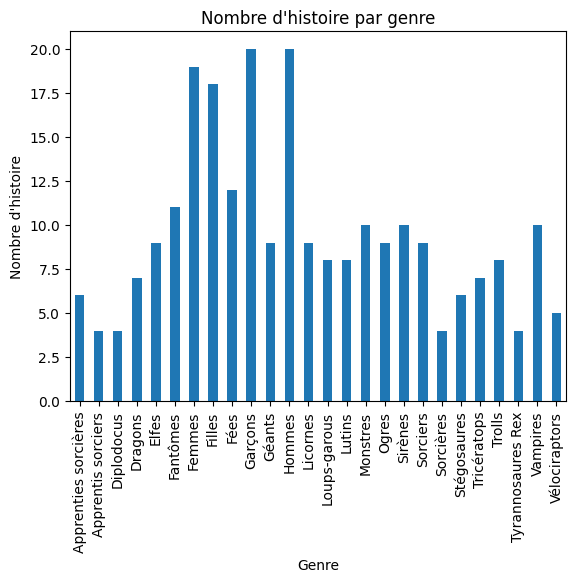

In [875]:
genre_story_count = df['Genre'].value_counts().sort_index()
genre_story_count.plot(kind='bar', xlabel='Genre', ylabel='Nombre d\'histoire', title='Nombre d\'histoire par genre')

In [852]:
!docker run --name postgres_story_db -d -p 5432:5432 -e POSTGRES_PASSWORD=story_pass postgres:alpine

cebdd751a987f157104f25b6cae9c91a29f41c637b09db957df7c2b424c6aa61


In [876]:
from sqlalchemy import create_engine

# Database credentials
user = 'postgres'
password = 'story_pass'
host = 'localhost'  # or the IP if your PostgreSQL server is running elsewhere
port = '5432'       # default port for PostgreSQL used by our docker above
db = 'postgres'

# Create the connection
engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{db}')

In [877]:
df['Glossaire'] = df['Glossaire'].apply(json.dumps)
df['Questions'] = df['Questions'].apply(json.dumps)

In [878]:
df

,Age,Titre,Histoire,Category,Genre,Questions,Glossaire
75,9 ans et plus,Le Voyageur des Étoiles et l'Orbe de Lumière,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Hommes,"[{""question1"": {""enonce"": ""Quel est le nom du ...","{""Interplan\u00e9taire"": ""Qui concerne plusieu..."
124,9 ans et plus,Léo et le Dragon Magique,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Hommes,"[{""question1"": {""enonce"": ""Quel \u00e9tait le ...","{""Contr\u00e9es"": ""R\u00e9gions ou territoires..."
76,9 ans et plus,Luna et les étoiles mystérieuses,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Femmes,"[{""question1"": {""enonce"": ""Quelle est la coule...","{""Runes"": ""Des symboles magiques utilis\u00e9s..."
123,9 ans et plus,L'Étoile Magique d'Astra,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Femmes,"[{""question1"": {""enonce"": ""Comment s'appelle l...","{""Firmament"": ""L'espace c\u00e9leste, la vo\u0..."
115,9 ans et plus,Les Pouvoirs de Léo,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Science Fantasy,Garçons,"[{""question1"": {""enonce"": ""Quel est le nom du ...","{""Inscriptions"": ""Gravures ou marques qui sont..."
...,...,...,...,...,...,...,...
52,3/4 ans,Louis et Harold : Le Royaume Magique de l'Aven...,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy humoristique (light fantasy),Garçons,"[{""question1"": {""enonce"": ""Quel est le nom du ...","{""Baguette magique"": ""B\u00e2ton magique utili..."
78,3/4 ans,Les Aventures Magiques de Super Léo,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy humoristique (light fantasy),Garçons,"[{""question1"": {""enonce"": ""Comment s'appelle l...","{""Intrigu\u00e9"": ""Qui se sent curieux ou int\..."
38,3/4 ans,Les Aventures Magiques de Lila dans la Forêt E...,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy humoristique (light fantasy),Filles,"[{""question1"": {""enonce"": ""Quel est le nom de ...","{""Lisi\u00e8re"": ""La bordure ou le bord d'une ..."
51,3/4 ans,Léa et la Petite Fée Farfelue,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy humoristique (light fantasy),Filles,"[{""question1"": {""enonce"": ""Que cherchait la Pe...","{""Farfelue"": ""Qui est un peu excentrique, extr..."


In [ ]:
time.sleep(10)

In [879]:
df.to_sql('story_table', engine, if_exists='replace', index=False)

In [ ]:
import psycopg2

#connect to the PostgreSQL database
conn = psycopg2.connect(dbname='postgres', user=user, password=password, host=host, port=port)

#create a cursor object
cursor = conn.cursor()

#list all tables in the database
cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table)

#check if job_table is created
if ('story_table',) in tables:
    print("\nTable 'story_table' exists.")
else:
    print("\nTable 'story_table' does not exist.")

#perform a verification query (e.g., selecting the first 5 rows)
query = "SELECT * FROM story_table LIMIT 5"
df = pd.read_sql(query, conn)
print("\nFirst 5 rows of 'story_table':")
print(df)

Tables in the database:
('story_table',)

Table 'story_table' exists.

First 5 rows of 'story_table':
             Age                                         Titre  \
0  9 ans et plus  Le Voyageur des Étoiles et l'Orbe de Lumière   
1  9 ans et plus                      Léo et le Dragon Magique   
2  9 ans et plus              Luna et les étoiles mystérieuses   
3  9 ans et plus                      L'Étoile Magique d'Astra   
4  9 ans et plus                           Les Pouvoirs de Léo   

                                            Histoire         Category  \
0  <div class="fs-lg">\n<h3 class="bg-primary tex...    Space fantasy   
1  <div class="fs-lg">\n<h3 class="bg-primary tex...    Space fantasy   
2  <div class="fs-lg">\n<h3 class="bg-primary tex...    Space fantasy   
3  <div class="fs-lg">\n<h3 class="bg-primary tex...    Space fantasy   
4  <div class="fs-lg">\n<h3 class="bg-primary tex...  Science Fantasy   

     Genre                                          Questions 

C:\Users\bertr\AppData\Local\Temp\ipykernel_13528\3596792087.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [859]:
!docker run -d --name mongo_story_db -p 27017:27017 mongo

7da10416820abcaeceb2ebe5c3ba653c1aaccf1a2acc8ba85cbb61d9960d4cb3


In [860]:
from pymongo import MongoClient

#connect to the MongoDB server (default is localhost on port 27017)
client = MongoClient('localhost', 27017)

#access the database (create it if it doesn't exist)
db = client['story_database']

#access the collection (similar to a table in relational databases)
collection = db['story_collection']

In [861]:
#convert DataFrame to dictionary format and insert into our MongoDB database
collection.insert_many(df.to_dict('records'))

InsertManyResult([ObjectId('660568a35319341895879052'), ObjectId('660568a35319341895879053'), ObjectId('660568a35319341895879054'), ObjectId('660568a35319341895879055'), ObjectId('660568a35319341895879056')], acknowledged=True)

In [862]:
cursor = collection.find({"Age": "9 ans et plus"})
for document in cursor:
    print(document)

{'_id': ObjectId('660568a35319341895879052'), 'Age': '9 ans et plus', 'Titre': "Le Voyageur des Étoiles et l'Orbe de Lumière", 'Histoire': '<div class="fs-lg">\n<h3 class="bg-primary text-light p-1 text-uppercase mt-5" style="display:inline-block;">Chapitre 1 : Le Destin du Voyageur</h3><p>Dans une galaxie lointaine, au-delà des étoiles, vivait un homme nommé Antoine. Il était un voyageur intergalactique, explorant les confins de l\'univers à bord de son vaisseau spatial, le <b>« Faucon des Étoiles »</b>. Antoine était un homme solitaire, mais il trouvait une grande satisfaction dans la découverte de nouvelles planètes, de nouvelles espèces et de nouvelles aventures.</p><p>Un jour, alors qu\'il voyageait à travers une<abbr class="bg-faded-primary" data-bs-toggle="tooltip" data-bs-placement="top" data-bs-html="true" data-bs-original-title="Un<span> </span>nuage<span> </span>de<span> </span>gaz<span> </span>et<span> </span>de<span> </span>poussière<span> </span>dans<span> </span>l\'espac

In [863]:
driver.quit()